In [1]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

import jax

from src.simulate_trace import MakePulse, apply_noise, GaussianAmplitude, PolynomialPhase, MultiPulse, RandomPhase

In [44]:

pulse_maker = MakePulse(N=128*20, Delta_f=2)

central_f = 0.275
phase = PolynomialPhase(0.3, (0,0,0,0))
amp = GaussianAmplitude((1,0.9,0.1), (0.275,0.35,0.2), (0.1,0.05,0.01))
time_inp, pulse_t_inp, frequency_inp, pulse_f_inp = pulse_maker.generate_pulse((amp, phase))


input_pulses = pulse_maker.pulses



# central_f = np.array([0.3])
# phase = PolynomialPhase(central_frequency=central_f, coefficients = np.array([0, 0, -250]))
# amp = GaussianAmplitude(central_frequency = central_f, amplitude = np.array([1.0]), fwhm = np.array([0.05]))
# _, _, frequency_gate, pulse_f_gate = pulse_maker.generate_pulse((amp, phase))


# delay, frequency, trace, spectra=pulse_maker.generate_frog(time_inp, frequency_inp, pulse_t_inp, pulse_f_inp, "shg", cross_correlation=True,
#                                                           gate=(frequency_gate, pulse_f_gate), real_fields=False, interpolate_fft_conform=True,
#                                                           N=128*2, scale_time_range=1.5, plot_stuff=True, cut_off_val=0.0001)#, frequency_range=(0.1,1.4))

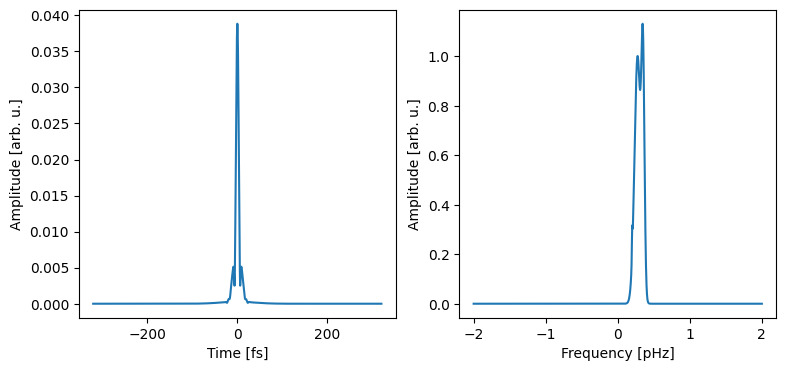

In [45]:
#time_inp, pulse_t_inp, frequency_inp, pulse_f_inp = pulse_maker.generate_pulse((amp, RandomPhase()))
pulse_maker.plot_pulses()

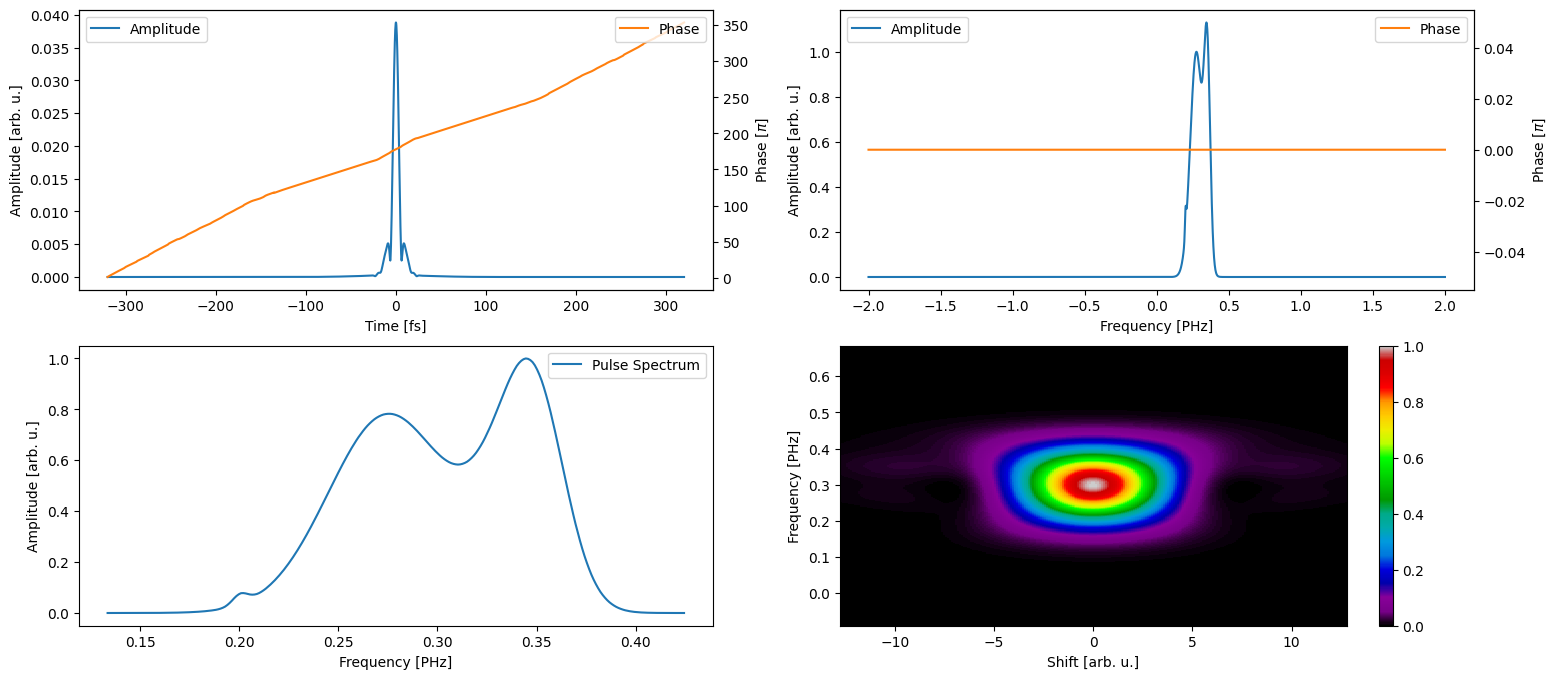

In [46]:
time, frequency, trace, spectra = pulse_maker.generate_frog(time_inp, frequency_inp, pulse_t_inp, pulse_f_inp, "pg", 
                                                            cross_correlation=False, ifrog=False, gate=(None, None), real_fields=False, 
                                                            frequency_range=None, N=256, cut_off_val=0.01, interpolate_fft_conform=False, 
                                                            scale_time_range=1, plot_stuff=True)

In [47]:
from src.frog import Vanilla

In [55]:
vanilla = Vanilla(time, frequency, trace, "pg")
population = vanilla.create_initial_population(5, "random")

final_result = vanilla.run(population, 5)

In [ ]:
from src.core.construct_s_prime import calculate_S_prime_projection
from src.utilities import calculate_mu, do_fft, MyNamespace

from jax.tree_util import Partial

In [ ]:
def split_population_real_imag(population, doubleblind):
    pulse_real, pulse_imag = jnp.real(population.pulse), jnp.imag(population.pulse)
    pulse = MyNamespace(real=pulse_real, imag=pulse_imag)
    if doubleblind==True:
        gate_real, gate_imag = jnp.real(population.gate), jnp.imag(population.gate)
        gate = MyNamespace(real=gate_real, imag=gate_imag)
    else:
        gate = None
    return MyNamespace(pulse=pulse, gate=gate)



def merge_real_imag_population(population, doubleblind):
    pulse_real, pulse_imag = population.pulse.real, population.pulse.imag
    pulse = pulse_real + 1j*pulse_imag
    if doubleblind==True:
        gate_real, gate_imag = population.gate.real, population.gate.imag
        gate = gate_real + 1j*gate_imag
    else:
        gate = None
    return MyNamespace(pulse=pulse, gate=gate)



def z_error_loss(individual, transform_arr, signal_t_new, measurement_info, descent_info, calc_signal_t):
    individual = merge_real_imag_population(individual, measurement_info.doubleblind)
    signal_t = calc_signal_t(individual, transform_arr, measurement_info)
    error = jnp.sum(jnp.abs(signal_t_new-signal_t)**2)
    return error

In [ ]:
def calc_Z_grad_AD(population, transform_arr, signal_t_new, measurement_info, descent_info, calc_signal_t):
    population = split_population_real_imag(population, measurement_info.doubleblind)

    loss_func = Partial(z_error_loss, measurement_info=measurement_info, descent_info=descent_info, calc_signal_t=calc_signal_t)
    calc_grad = jax.grad(loss_func, argnums=0)
    grad = jax.vmap(calc_grad, in_axes=(0,None,None))(population, transform_arr, signal_t_new)

    grad = merge_real_imag_population(grad, measurement_info.doubleblind)
    return grad.pulse, grad.gate